In [42]:
# Copyright 2025 Luke Moffett
# Licensed under the Apache License, Version 2.0

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch

from transformers import pipeline
from pathlib import Path

tqdm.tqdm.pandas()

from IPython.display import display

from clz_or_cls import hot, perturbation

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

plt.rcParams['figure.dpi'] = 100
%matplotlib inline

In [ ]:
hot_df = pd.read_csv('data/datasets/hot/hot-dataset.csv')
hot_df.iloc[0]['text']

<AxesSubplot: >

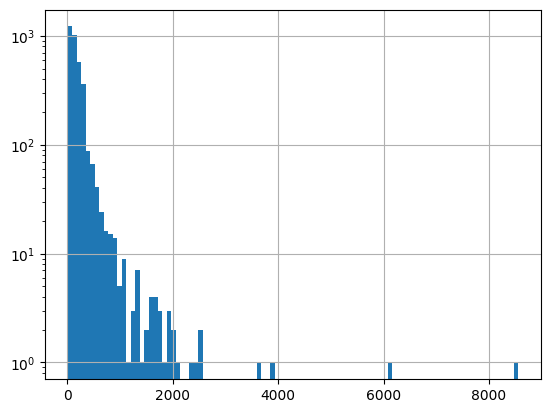

In [3]:
hot_df['text'].str.len().hist(bins=100, log=True)

In [ ]:
# Need to exclude the 9 messages with more than 2000 characters to have space in the context window
hot_df[hot_df['text'].str.len()>2000]['text'].describe()

In [5]:
hot_marked_df = hot.hot_speech_marked(as_df=True)
hot_marked_df.columns

Index(['ID', 'text', 'link', 'hateful_hard', 'hateful_soft', 'hateful_stats',
       'offensive_hard', 'offensive_soft', 'offensive_stats', 'toxic_hard',
       'toxic_soft', 'toxic_stats', 'composite_hateful_hard',
       'composite_hateful_soft', 'composite_hateful_stats',
       'composite_offensive_hard', 'composite_offensive_soft',
       'composite_offensive_stats', 'composite_toxic_hard',
       'composite_toxic_soft', 'composite_toxic_stats', 'accusation',
       'behavior', 'benign', 'communication_style',
       'composite_hateful_rater_effect', 'composite_offensive_rater_effect',
       'composite_toxic_rater_effect', 'context_necessary', 'directed',
       'first', 'group', 'group_or_individual', 'hateful_only',
       'hateful_rater_effect', 'individual', 'insult', 'misinformation',
       'multiple_behaviors', 'namecalling', 'not_first', 'offensive_only',
       'offensive_rater_effect', 'overlap', 'overlap_ho', 'overlap_hot',
       'overlap_ht', 'overlap_ot', 'sarcasm',

In [ ]:
hot_perturbable_df = hot_marked_df[(hot_marked_df['candidate_ratio'] >= .5) & 
                      (hot_marked_df['num_replacement_candidates'] >= 8) & 
                      (hot_marked_df['text'].str.len() <= 2000)].copy()

hot_perturbable_df.groupby(['hateful_hard', 'offensive_hard', 'toxic_hard']).count().reset_index().sort_values(['hateful_hard', 'offensive_hard', 'toxic_hard'], ascending=False)

In [7]:
assert hot_perturbable_df[hot_perturbable_df['num_replacement_candidates'] >= 8].shape == hot_perturbable_df.shape

# Label the Replacement Candidates

In [ ]:
hot_perturbable_df['tokenized_sentence']

In [ ]:
hot_perturbable_df['replacement_candidates'].iloc[0]

In [14]:
def replace_with_missing(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    sentences_with_missing = []
    for replace_word in set(words):
        sentences_with_missing.append((replace_word, ' '.join(word if word != replace_word else '[UNK]' for word in words)))
    return sentences_with_missing

# Test the function
test_sentence = "lets all sue Sue"
replaced_sentences = replace_with_missing(test_sentence)
replaced_sentences

[('lets', '[UNK] all sue sue'),
 ('all', 'lets [UNK] sue sue'),
 ('sue', 'lets all [UNK] [UNK]')]

In [ ]:
pipe = pipeline("text-classification", model="facebook/roberta-hate-speech-dynabench-r4-target")

In [16]:
r_df = pd.DataFrame(replaced_sentences, columns=['word', 'sentence'])
df = pd.DataFrame(pipe(list(r_df['sentence'])))
results = pd.merge(df, r_df, left_index=True, right_index=True)
results['score'].mean()

0.8865693012873331

In [17]:
results['influence'] = (results['score'] - results['score'].mean()).abs()
results

,label,score,word,sentence,influence
0,nothate,0.692644,lets,[UNK] all sue sue,0.193925
1,nothate,0.981289,all,lets [UNK] sue sue,0.094720
2,nothate,0.985775,sue,lets all [UNK] [UNK],0.099205


### Run Sentiment Ordering to get Dataframe

In [ ]:
priority_df = pd.DataFrame()
for idx, row in tqdm.tqdm(hot_perturbable_df.iterrows()):
    
    sentences = replace_with_missing(row['tokenized_sentence'])
    r_df = pd.DataFrame(sentences, columns=['word', 'sentence'])
    df = pd.DataFrame(pipe(list(r_df['sentence'])))
    # df = pd.DataFrame.from_dict({
    #     'label': ['hate'] * len(r_df['sentence']),
    #     'score': np.random.random(len(r_df['sentence']))   
    # })

    results = pd.merge(df, r_df, left_index=True, right_index=True)
    results['idx'] = idx
    results['abs_score'] = results.apply(lambda row: ((-1 if row['label'] == 'hate' else 1) * row['score']), axis=1)
    results['influence'] = (results['abs_score'] - results['abs_score'].mean()).abs()

    results = results.set_index('idx')

    results = results.sort_values('influence', ascending=False)
    results['priority'] = list(range(len(results)))
    
    priority_df = pd.concat([priority_df, results])

In [ ]:
prep_path = Path(os.environ['CORC_DATASETS_PREP_DIR'])
priority_df.to_csv(prep_path/'hot'/'hot-replacement-priority.csv')

In [ ]:
prep_path = Path(os.environ['CORC_DATASETS_PREP_DIR'])
priority_df = pd.read_csv(prep_path/'hot'/'hot-replacement-priority.csv')

In [ ]:
priority_df.reset_index().sort_values(['influence'], ascending=False).head(40)

In [23]:
def create_sorted_perturbation_candidates(row, omit_outstanding=False):
    matching_words = priority_df[priority_df['idx'] == row['ID']]

    scored_candidates = row['replacement_candidates'].intersection(set(matching_words['word']))

    sorted_matched_words = list(matching_words[matching_words['word'].isin(scored_candidates)].sort_values('influence', ascending=False)['word'])
    outstanding_words = row['replacement_candidates'] - set(sorted_matched_words)
    
    if omit_outstanding:
        return sorted_matched_words
    else:
        return sorted_matched_words + list(outstanding_words)

hot_perturbable_df['sorted_candidates'] = hot_perturbable_df.apply(create_sorted_perturbation_candidates, axis=1)

<AxesSubplot: >

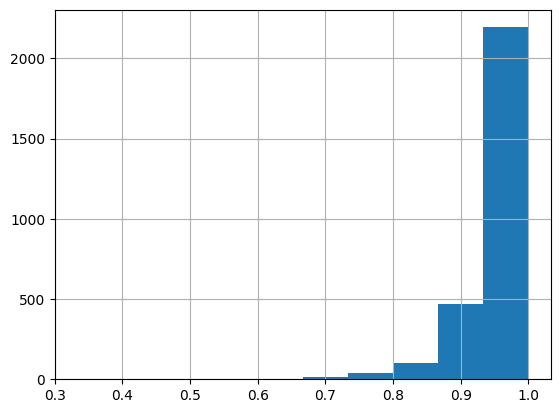

In [24]:
ser = hot_perturbable_df.apply(lambda r: create_sorted_perturbation_candidates(r, omit_outstanding=True), axis=1)
(ser.apply(len)/hot_perturbable_df['replacement_candidates'].apply(len)).hist()

In [25]:
(hot_perturbable_df['sorted_candidates'].apply(len) == hot_perturbable_df['replacement_candidates'].apply(len)).value_counts()

True    2830
dtype: int64

In [26]:
(hot_perturbable_df['sorted_candidates'].apply(len)/hot_perturbable_df['replacement_candidates'].apply(len)).value_counts()

1.0    2830
dtype: int64

In [ ]:
display(hot_perturbable_df.iloc[1]['text'])
display(' '.join(hot_perturbable_df.iloc[1]['sorted_candidates']))

In [29]:
hot_perturbable_df['perturbation_buckets'] = hot_perturbable_df['sorted_candidates'].apply(lambda s: np.random.rand(len(s)))
hot_perturbable_df['perturbation_buckets'].head(3)

0    [0.4132711986269819, 0.7133808273901997, 0.382...
1    [0.9724016762893568, 0.8311342466894437, 0.484...
2    [0.32916653155057385, 0.20504929361739999, 0.0...
Name: perturbation_buckets, dtype: object

In [30]:
annotator_accs = {"visual":
 {"legit": 60.4, "dces": 83.0},
 "phonetic": 
 {"phonee": 74.3, "zeroe_phonetic": 50.0},
 "typo": 
 {"zeroe_noise": 68.9, "zeroe_typo": 53.3}
}

strategy_thresholds = {
    'visual': 0,
    'phonetic': 0,
    'typo': 0
}

alphas = {}

for clazz, accs in annotator_accs.items():
    (name1, acc1), (name2, acc2) = accs.items()

    alphas[clazz] = {
        'class_idx': [(0, name1), (1, name2)],
        'alpha': (65.5 - acc2) / (acc1 - acc2)
    }

alphas

{'visual': {'class_idx': [(0, 'legit'), (1, 'dces')],
  'alpha': 0.7743362831858407},
 'phonetic': {'class_idx': [(0, 'phonee'), (1, 'zeroe_phonetic')],
  'alpha': 0.6378600823045268},
 'typo': {'class_idx': [(0, 'zeroe_noise'), (1, 'zeroe_typo')],
  'alpha': 0.7820512820512818}}

In [31]:
classes = ['visual', 'phonetic', 'typo']
for clazz in classes:
    def map_rand_to_class(rand):
        alpha = alphas[clazz]['alpha']

        return (np.array(rand) >= alpha).astype(int)
    
    hot_perturbable_df[f'{clazz}_buckets'] = hot_perturbable_df['perturbation_buckets'].apply(map_rand_to_class)

hot_perturbable_df[[f'{clazz}_buckets' for clazz in classes]]

,visual_buckets,phonetic_buckets,typo_buckets
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, ..."
1,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]","[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]"
...,...,...,...
3476,"[0, 0, 0, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 1, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
3477,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"
3478,"[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]","[1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]","[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]"
3479,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [120]:
hot_perturbable_df.to_csv(prep_path/'hot'/'hot_perturbation_metadata.csv')

In [ ]:
hot_perturbable_df = pd.read_csv(prep_path/'hot'/'hot_perturbation_metadata.csv', index_col='ID')
hot_perturbable_df = hot_perturbable_df.reset_index()
hot_perturbable_df

# Unify Metadata

This section is run **after** using 'hot_perturbation_metadata.csv' to actually attack the abstracts and generate the new datasets.
See `clz_or_cls.processes.hot_candidates.py`.

There will 6 datasets, one for each attack used.
This section unifies the attacks by class so that there is a single `visual`, `phonetic`, and `typo` file.

In [33]:
hot_strats = {
    'visual': ('legit', 'dces'),
    'phonetic': ('phonee', 'zeroe_phonetic'),
    'typo': ('zeroe_noise', 'zeroe_typo')
}
hot_strats

{'visual': ('legit', 'dces'),
 'phonetic': ('phonee', 'zeroe_phonetic'),
 'typo': ('zeroe_noise', 'zeroe_typo')}

In [ ]:
import ast
replacements_df = None

for clazz, strats in hot_strats.items():
    for strategy in strats:
        strat_df = pd.read_csv(prep_path/'hot'/f'hot-{strategy}.csv').set_index('Unnamed: 0')
        # strat_df.rename('index')
        strat_df[f'replacements_{strategy}'] = strat_df['replacement_candidates'].apply(ast.literal_eval)
        if replacements_df is None:
            replacements_df = strat_df[[f'replacements_{strategy}']]
        else:
            replacements_df = replacements_df.merge(strat_df[[f'replacements_{strategy}']], left_index=True, right_index=True)

replacements_df.index.rename('idx', inplace=True)
replacements_df

In [ ]:
hot_perturbable_with_replacements_df = hot_perturbable_df.merge(replacements_df, left_index=True, right_index=True)
hot_perturbable_with_replacements_df

In [38]:
hot_perturbable_df.columns

Index(['ID', 'Unnamed: 0', 'text', 'link', 'hateful_hard', 'hateful_soft',
       'hateful_stats', 'offensive_hard', 'offensive_soft', 'offensive_stats',
       'toxic_hard', 'toxic_soft', 'toxic_stats', 'composite_hateful_hard',
       'composite_hateful_soft', 'composite_hateful_stats',
       'composite_offensive_hard', 'composite_offensive_soft',
       'composite_offensive_stats', 'composite_toxic_hard',
       'composite_toxic_soft', 'composite_toxic_stats', 'accusation',
       'behavior', 'benign', 'communication_style',
       'composite_hateful_rater_effect', 'composite_offensive_rater_effect',
       'composite_toxic_rater_effect', 'context_necessary', 'directed',
       'first', 'group', 'group_or_individual', 'hateful_only',
       'hateful_rater_effect', 'individual', 'insult', 'misinformation',
       'multiple_behaviors', 'namecalling', 'not_first', 'offensive_only',
       'offensive_rater_effect', 'overlap', 'overlap_ho', 'overlap_hot',
       'overlap_ht', 'overlap_o

In [ ]:
def materialize_candidates(clazz):
    strat0, strat1 = hot_strats[clazz]
    def materialize(row):
        
        buckets = ast.literal_eval(row[f'{clazz}_buckets'].replace(' ', ','))
        sorted_candidates = ast.literal_eval(row['sorted_candidates'])
        replacements = row[f'replacements_{strat0}'], row[f'replacements_{strat1}']

        tuples = []

        for candidate, strat_idx in zip(sorted_candidates, buckets):
            tuples.append((candidate, replacements[strat_idx][candidate]))
        
        return tuples
    
    return materialize

for clazz in hot_strats.keys():
    hot_perturbable_with_replacements_df[f'replacements_{clazz}'] = hot_perturbable_with_replacements_df.apply(materialize_candidates(clazz), axis=1)

hot_perturbable_with_replacements_df[[f'replacements_{clazz}' for clazz in hot_strats.keys()]]

In [52]:
hot_perturbable_with_replacements_df[[f'replacements_{clazz}' for clazz in hot_strats.keys()]].to_csv(prep_path/'hot'/'hot-class-replacements.csv')

#### Sanity Check Merge

In [ ]:
class_replacements_df = pd.read_csv(prep_path/'hot'/'hot-class-replacements.csv')
class_replacements_df

In [ ]:
hot_perturbable_df.merge(class_replacements_df, left_index=True, right_index=True)

In [40]:
hp_df = hot_perturbable_df.merge(class_replacements_df, left_index=True, right_index=True)

### Check that all strings can be Perturbed

In [ ]:
import ast
def perturb_text(row):
    clazz = 'visual'
    ratio = 1.0
    return perturbation.perturb_ratio(row['text'], ast.literal_eval(row[f'replacements_{clazz}']), ratio=ratio)

hp_df.progress_apply(perturb_text, axis=1)

In [ ]:
import ast
def perturb_text(row):
    clazz = 'phonetic'
    ratio = 1.0
    return perturbation.perturb_ratio(row['text'], ast.literal_eval(row[f'replacements_{clazz}']), ratio=ratio)

hp_df.progress_apply(perturb_text, axis=1)

In [ ]:
import ast
def perturb_text(row):
    clazz = 'typo'
    ratio = 1.0
    return perturbation.perturb_ratio(row['text'], ast.literal_eval(row[f'replacements_{clazz}']), ratio=ratio)

hp_df.progress_apply(perturb_text, axis=1)

### Check HF Dataset Version Loads Correctly

In [ ]:
hot.hot_metadata_df()

In [47]:
hot.hot_metadata_ds()

Dataset({
    features: ['ID', 'Unnamed: 0_x', 'text', 'link', 'hateful_hard', 'hateful_soft', 'hateful_stats', 'offensive_hard', 'offensive_soft', 'offensive_stats', 'toxic_hard', 'toxic_soft', 'toxic_stats', 'composite_hateful_hard', 'composite_hateful_soft', 'composite_hateful_stats', 'composite_offensive_hard', 'composite_offensive_soft', 'composite_offensive_stats', 'composite_toxic_hard', 'composite_toxic_soft', 'composite_toxic_stats', 'accusation', 'behavior', 'benign', 'communication_style', 'composite_hateful_rater_effect', 'composite_offensive_rater_effect', 'composite_toxic_rater_effect', 'context_necessary', 'directed', 'first', 'group', 'group_or_individual', 'hateful_only', 'hateful_rater_effect', 'individual', 'insult', 'misinformation', 'multiple_behaviors', 'namecalling', 'not_first', 'offensive_only', 'offensive_rater_effect', 'overlap', 'overlap_ho', 'overlap_hot', 'overlap_ht', 'overlap_ot', 'sarcasm', 'second', 'third', 'threat', 'toxic_only', 'toxic_rater_effect'

In [48]:
hot.class_perturbed_hot_dataset('visual', .01)

Parameter 'function'=<function class_perturbed_hot_dataset.<locals>.apply_perturbation at 0x7f1854f9af70> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/2830 [00:00<?, ? examples/s]

Dataset({
    features: ['ID', 'Unnamed: 0_x', 'text', 'link', 'hateful_hard', 'hateful_soft', 'hateful_stats', 'offensive_hard', 'offensive_soft', 'offensive_stats', 'toxic_hard', 'toxic_soft', 'toxic_stats', 'composite_hateful_hard', 'composite_hateful_soft', 'composite_hateful_stats', 'composite_offensive_hard', 'composite_offensive_soft', 'composite_offensive_stats', 'composite_toxic_hard', 'composite_toxic_soft', 'composite_toxic_stats', 'accusation', 'behavior', 'benign', 'communication_style', 'composite_hateful_rater_effect', 'composite_offensive_rater_effect', 'composite_toxic_rater_effect', 'context_necessary', 'directed', 'first', 'group', 'group_or_individual', 'hateful_only', 'hateful_rater_effect', 'individual', 'insult', 'misinformation', 'multiple_behaviors', 'namecalling', 'not_first', 'offensive_only', 'offensive_rater_effect', 'overlap', 'overlap_ho', 'overlap_hot', 'overlap_ht', 'overlap_ot', 'sarcasm', 'second', 'third', 'threat', 'toxic_only', 'toxic_rater_effect'